Imports

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Make the original data

In [2]:
series = np.sin((0.1 * np.arange(400)) ** 2)

This is a time series of form:

$x(t) = sin(\omega t^2)$

Plot it

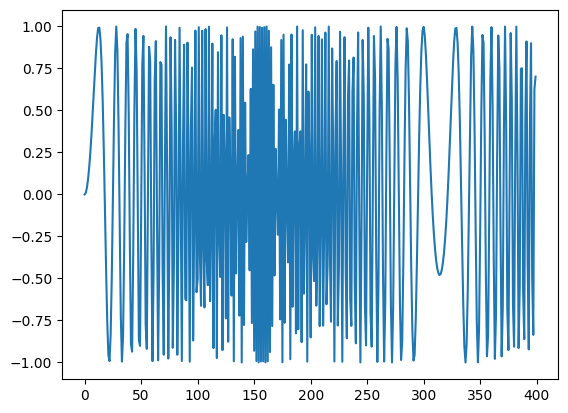

In [4]:
plt.plot(series);

Build the dataset

Let's see if we can use T past values to predict the next value

In [5]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  X.append(series[t:t+T])
  Y.append(series[t + T])
X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


# Try autoregressive linear model

In [6]:
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [7]:
r = model.fit(
    X[:-N//2], Y[:N//2],
    validation_data=(X[-N//2:], Y[-N//2:]),
    epochs=80
)

Epoch 1/80
7/7 [==============================] - 2s 48ms/step - loss: 1.8400 - val_loss: 1.2101
Epoch 2/80
7/7 [==============================] - 0s 14ms/step - loss: 1.5551 - val_loss: 1.0745
Epoch 3/80
7/7 [==============================] - 0s 10ms/step - loss: 1.3277 - val_loss: 0.9473
Epoch 4/80
7/7 [==============================] - 0s 10ms/step - loss: 1.1523 - val_loss: 0.8409
Epoch 5/80
7/7 [==============================] - 0s 11ms/step - loss: 1.0032 - val_loss: 0.7658
Epoch 6/80
7/7 [==============================] - 0s 10ms/step - loss: 0.8901 - val_loss: 0.7120
Epoch 7/80
7/7 [==============================] - 0s 13ms/step - loss: 0.8048 - val_loss: 0.6705
Epoch 8/80
7/7 [==============================] - 0s 13ms/step - loss: 0.7355 - val_loss: 0.6395
Epoch 9/80
7/7 [==============================] - 0s 12ms/step - loss: 0.6856 - val_loss: 0.6125
Epoch 10/80
7/7 [==============================] - 0s 13ms/step - loss: 0.6510 - val_loss: 0.5899
Epoch 11/80
7/7 [============

Plot loss per iteration

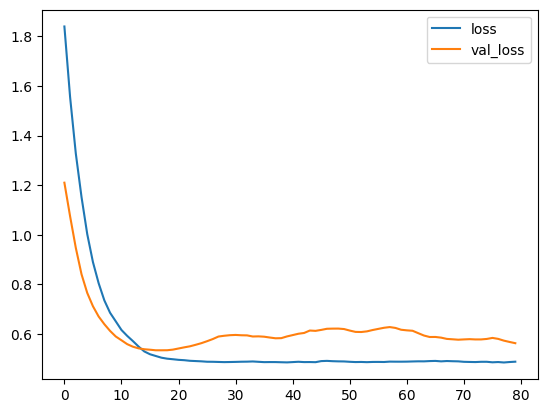

In [9]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

One-step forecast using true targets

Note: even the one-step forecast fails badly

In [10]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

13/13 [==============================] - 0s 1ms/step
(390, 1)


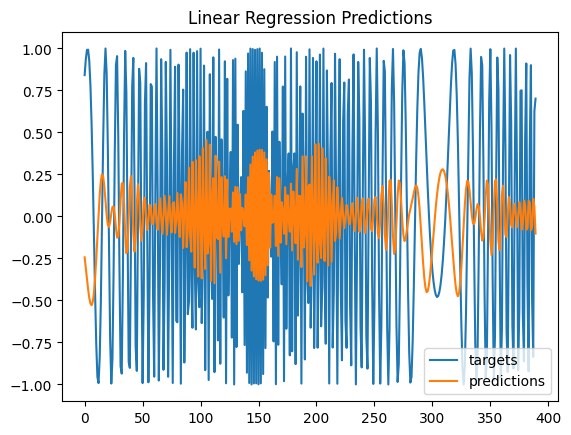

In [11]:
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend();

One-step forecast

In [13]:
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N // 2
while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0, 0] # 1x1 array -> scalar
  i += 1
  validation_predictions.append(p)

1/1 [==============================] - 0s 31ms/step


Plot the predictions of the forecast

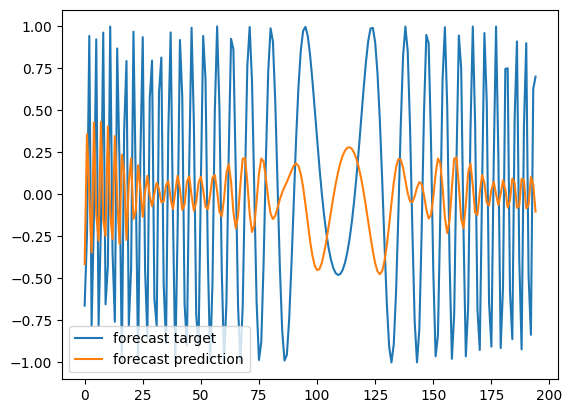

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

Multi-step forecast

In [15]:
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0, 0] # 1x1 array -> scalar
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


1/1 [==============================] - 0s 21ms/step


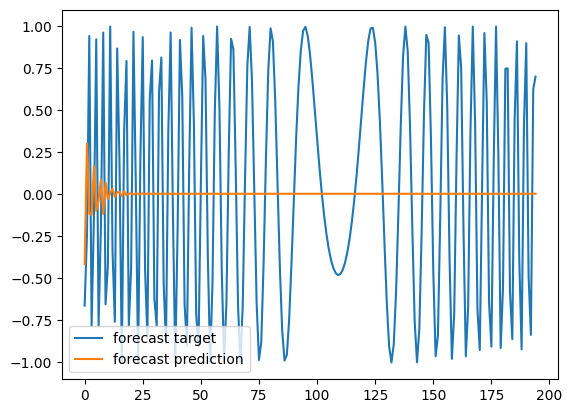

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

# Now try RNN/LSTM model

In [17]:
X = X.reshape(-1, T, 1) # make it N x T x D

Make the RNN

In [36]:
i = Input(shape=(T, D))
x = LSTM(10)(i)
x=  Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.05))

Train the RNN

In [37]:
r = model.fit(
    X[:-N//2], Y[:N//2],
    validation_data=(X[-N//2:], Y[-N//2:]),
    epochs=200, batch_size=32
)

Epoch 1/200
7/7 [==============================] - 3s 96ms/step - loss: 0.5386 - val_loss: 0.6028
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4858 - val_loss: 0.6092
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.4089 - val_loss: 0.5979
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 0.4097 - val_loss: 0.4159
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 0.3223 - val_loss: 0.3753
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 0.2343 - val_loss: 0.3169
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 0.1794 - val_loss: 0.2600
Epoch 8/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0963 - val_loss: 0.2145
Epoch 9/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0592 - val_loss: 0.1750
Epoch 10/200
7/7 [==============================] - 0s 20ms/step - loss: 0.0570 - val_loss: 0.1416
Epoch 11/200
7/7 [=

Plot loss per iteration

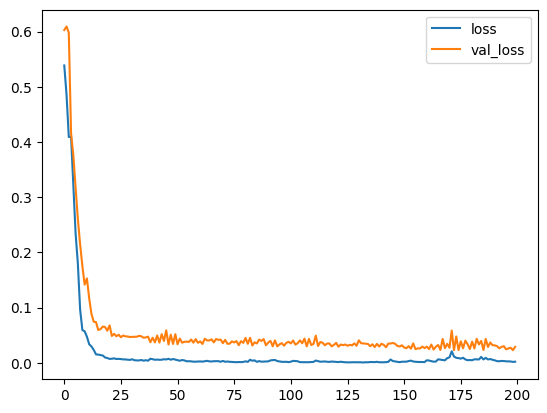

In [38]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

One-step forecast using true targets

In [39]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

13/13 [==============================] - 0s 2ms/step
(390, 1)


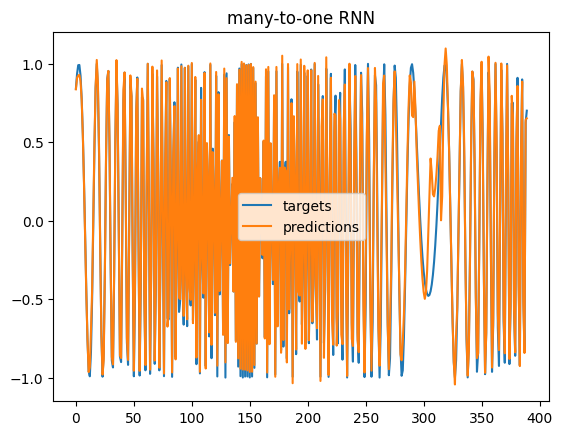

In [40]:
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend();

Multi-step forecast

In [41]:
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0, 0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

1/1 [==============================] - 0s 26ms/step


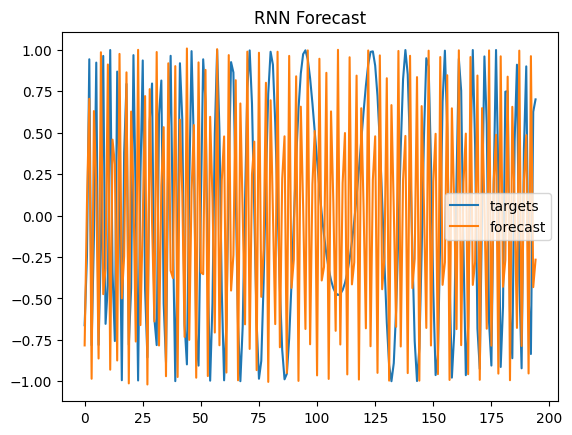

In [42]:
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend();